## LFV Limits from $\ell_i\rightarrow\ell_j\gamma$ decay rate

In this notebook, we generate limits on LFV scalars and ALPs for the $\ell_i \rightarrow \ell_j\gamma$ decay rates. 

In [1]:
#For numerics
import numpy as np

#For loading and saving data
import pandas as pd

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For setting root path
import sys
import os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root not in sys.path:
    sys.path.append(root)
    
#Rate functions
from dipole_form_factors.formulae.decay_rates import (rate_ij,
                                                      rate_ijk,
                                                      rate_ALP_photon,
                                                      decay_rates,
                                                      branching_limits)

from phys.constants import me, mm, mt, ml

Some helper functions for opening the form-factor function files:

In [2]:
def str_to_tuple(str_tuple):
    return tuple([int(i) for i in str_tuple[1:-1].split(',')])

def extract_f_dict(file):
    df = pd.read_csv(file, index_col = 0)
    
    df.columns = [str_to_tuple(col) for col in df.columns]
    
    f_dict = {'mass': df.index.to_numpy(dtype = np.float64)}
    for col in df.columns:
        f_dict[col] = df[col].to_numpy(dtype = np.complex128)
    return f_dict

Extract the relevant form-factor functions:

In [3]:
func_names = ['f2_plus', 'f2_minus', 'f3_plus', 'f3_minus']
functions = []
for func_name in func_names:
    file = root + f'/dipole_form_factors/data/{func_name}.csv'
    functions.append(extract_f_dict(file))
f2p, f2m, f3p, f3m = functions

Compute LFV decay rates for the processes $\ell_i \stackrel{\ell_k}{\longrightarrow}\ell_j\gamma$, and save for use in other analyses:

In [4]:
leptons = ['e', '\\mu', '\\tau']
processes = [(1, 0), (2, 0), (2, 1)]
sub_processes = [(1, 0, 0), (1, 0, 1), (1, 0, 2),
                 (2, 0, 0), (2, 0, 1), (2, 0, 2),
                 (2, 1, 0), (2, 1, 1), (2, 1, 2)]

def process_label(process):
    i, j, k = process
    return f'${leptons[i]}\\stackrel{{{leptons[k]}}}{{\\longrightarrow}}{leptons[j]}\\gamma$'

labels = [process_label(process) for process in sub_processes]
labels = dict(zip(sub_processes, labels))

m = f2p['mass']

limits = {}

for mode in ['PC', 'chiral']:
    lim = {}
    for ALP in [False, True]:
        l = {'mass': m}
        particle = 'ALP' if ALP else 'scalar'
        for process in sub_processes:
            i, j, _ = process
            rate = rate_ijk(f2p, f2m, f3p, f3m, *process, mode = mode, ALP = ALP)
            l[process] = np.power(decay_rates[i]*branching_limits[(i, j)]/rate, 1/4)
                        
        for process in processes:
            i, j = process
            if ALP:
                rate = rate_ALP_photon(m, *process)
                l[process + (3, )] = np.power(decay_rates[i]*branching_limits[(i, j)]/rate, 1/4)
            rate = rate_ij(f2p, f2m, f3p, f3m, *process, mode = mode, ALP = ALP)
            l[process] = np.power(decay_rates[i]*branching_limits[(i, j)]/rate, 1/4)
            
        file = os.getcwd() + f'/data/LFV_{mode}_{particle}_limits.csv'
        df = pd.DataFrame(l)
        df.to_csv(file, index = False)
        
        lim[particle] = l
    limits[mode] = lim

/Volumes/T7/Research/Thesis/phys/formulae/ALP_EFT.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  th[i,j] = np.arctan((mf[i]+mf[j])/(mf[i]-mf[j]) / np.tan(TH[i][j]))


Helper function for plotting the limits on the couplings from the LFV decay rate $\ell_i\stackrel{\ell_k}{\longrightarrow}\ell_j\gamma$:

In [5]:
def plot_coupling_limits(process, ax = None, ALP = False):
    if not ax:
        fig, ax = plt.subplots()
    
    particle = 'ALP' if ALP else 'scalar'
    
    i, j = process
    li, lj = leptons[i], leptons[j]

    plot_labels = [labels[process + (k,)] for k in range(3)]
    phot_label = f'${li}\\stackrel{{\\gamma}}{{\\longrightarrow}} {lj}\\gamma$'
    sum_label = f'${li}\\longrightarrow {lj}\\gamma~(\\textrm{{sum}})$'
    
    #calculate absolute minimum to shade in
    minimum = 1e16
    
    #PC plots
    for k in range(3):
        ax.plot(m, limits['PC'][particle][process + (k,)],
                color = colors[k],
                label = plot_labels[k])
    
        
        minimum = np.minimum(minimum, limits['PC'][particle][process + (k,)])

    if ALP:
        ax.plot(m, limits['PC']['ALP'][process + (3,)],
                color = 'grey',
                linestyle = 'dotted',
                label = phot_label)
        minimum = np.minimum(minimum,limits['PC']['ALP'][process + (3,)])
                
    ax.plot(m, limits['PC'][particle][process],
            color = 'black',
            label = sum_label)

    minimum = np.minimum(minimum, limits['PC'][particle][process])
        
    #chiral plots
    for k in range(3):
        ax.plot(m, limits['chiral'][particle][process + (k,)],
                color = colors[k],
                linestyle = 'dashed')
    
        minimum = np.minimum(minimum, limits['chiral'][particle][process + (k,)])
        
    ax.plot(m, limits['chiral'][particle][process],
            color = 'black',
            linestyle = 'dashed')

    minimum = np.minimum(minimum, limits['chiral'][particle][process])

    ax.fill_between(m, minimum, 1e10, color = 'yellow', alpha = 0.05)
    
    legend = ax.legend(fancybox = False,
                       fontsize = 10,
                       facecolor = 'white',
                       edgecolor = 'black',
                       loc = 'lower right')
    ax.add_artist(legend)
    
    #This is only for the first plot
    ax.plot([1000], color = 'grey', label = f'$\\textrm{{pure {particle}}}$')
    ax.plot([1000], color = 'grey', label = f'$\\chi\\textrm{{ {particle}}}$', linestyle = 'dashed')

    particle_handles, particle_labels = plt.gca().get_legend_handles_labels()
    particle_handles, particle_labels = particle_handles[-2:], particle_labels[-2:]

    ax.legend(particle_handles, particle_labels,
              frameon = False,
              fontsize = 8,
              loc = 'upper left')

    ax.tick_params(direction = 'in', which = 'both')
    ax.grid()

    ax.set_xscale('log')
    
    ax.set_xlim(1e0, 1e2*(1 if ALP else 10))
    if ALP:
        ax.set_xlabel("$m_a~[\\textrm{GeV}]$", fontsize = 14)
    else:
        ax.set_xlabel("$m_\\varphi~[\\textrm{GeV}]$", fontsize = 14)

    ax.set_yscale('log')
    ymin, ymax = [1e-4, 1e3] if ALP else [1e-7, 1e0]
    ax.set_ylim(ymin, ymax)

    if ALP:
        ylabel =f'$\\sqrt{{C_{{{li} k}}C_{{{lj} k}}}}/\\Lambda~[\\textrm{{TeV}}]^{{-1}}$'
    else:
        ylabel =f'$\\sqrt{{g_{{{li} k}}g_{{{lj} k}}}}$'
    ax.set_ylabel(ylabel, fontsize = 14)
    
    return ax

Limits on scalars:

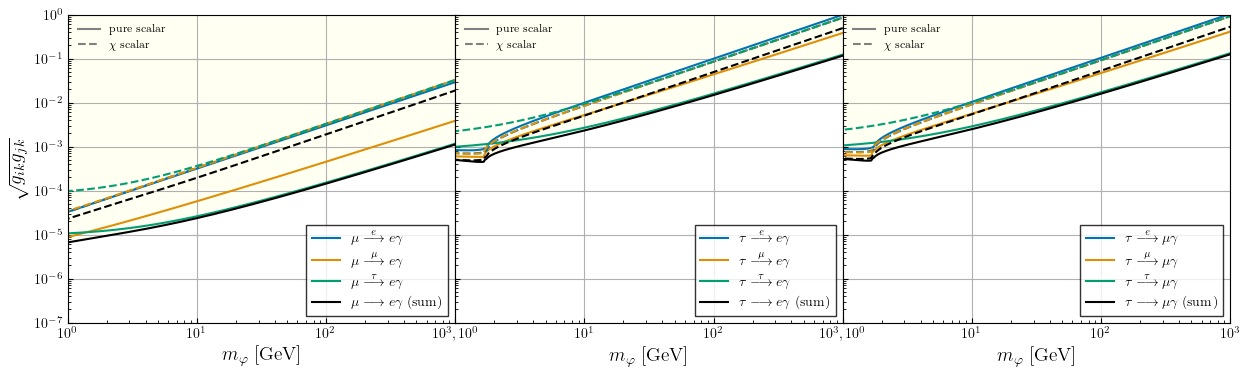

In [6]:
fig = plt.figure(figsize=(15, 4))
gs = GridSpec(1, 3, figure = fig, wspace = 0)

for idx, process in enumerate(processes): 
    ax = fig.add_subplot(gs[idx])
    ax = plot_coupling_limits(process, ax = ax, ALP = False)
    
    if idx == 0:
        ax.set_ylabel("$\\sqrt{g_{ik}g_{jk}}$")
    
    if idx > 0:
        ax.tick_params(labelleft = False)
        ax.set_ylabel(None)
    
    #fix xticks
    xticks = [1e0, 1e1, 1e2] if idx < 2 else [1e0, 1e1, 1e2, 1e3]
    xtick_labels = ["$10^0$", "$10^1$", "$10^2$"] if idx == 0 else ["$10^3, 10^0$", "$10^1$", "$10^2$"]
    if idx == 2:
        xtick_labels += ["$10^3$"]
    ax.set_xticks(xticks, xtick_labels)
    
plt.savefig(root + '/figures/chapter3/LFV_scalar_decay_limits.pdf', format = 'pdf')

Limits on ALPs:

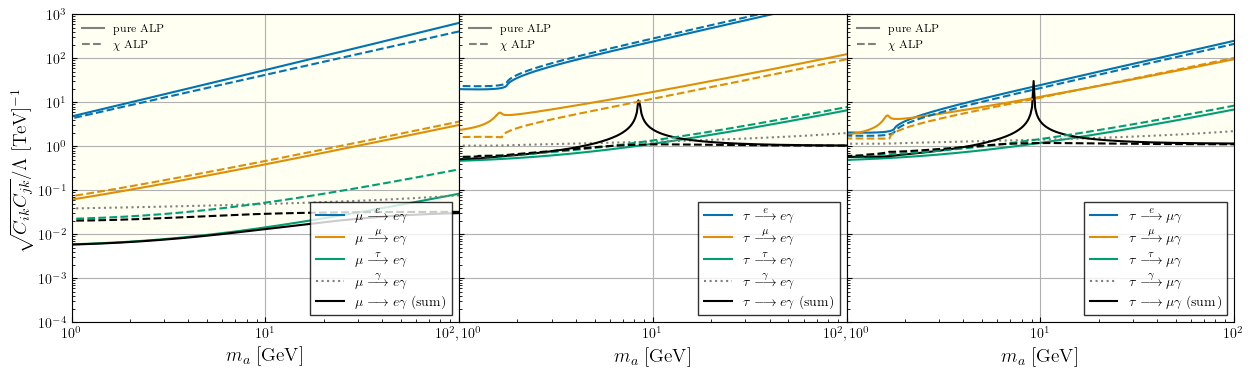

In [7]:
fig = plt.figure(figsize=(15, 4))
gs = GridSpec(1, 3, figure = fig, wspace = 0)

for idx, process in enumerate(processes): 
    ax = fig.add_subplot(gs[idx])
    ax = plot_coupling_limits(process, ax = ax, ALP = True)
    
    if idx == 0:
        ax.set_ylabel("$\\sqrt{C_{ik}C_{jk}}/\\Lambda~[\\textrm{TeV}]^{-1}$")
    
    if idx > 0:
        ax.tick_params(labelleft = False)
        ax.set_ylabel(None)
    
    #fix xticks
    xticks = [1e0, 1e1] if idx < 2 else [1e0, 1e1, 1e2]
    xtick_labels = ["$10^0$", "$10^1$"] if idx == 0 else ["$10^2, 10^0$", "$10^1$"]
    if idx == 2:
        xtick_labels += ["$10^2$"]
    ax.set_xticks(xticks, xtick_labels)

plt.savefig(root + '/figures/chapter3/LFV_ALP_decay_limits.pdf', format = 'pdf')